# XKCD Character Identification

Application of FastAI multi-label image classification on comic panels  
Based on FastAI deep learning tutorials  
Comics from xkcd.com

## Installing Packages

In [0]:
from fastai.vision import *
import numpy as np
import pandas as pd

In [0]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

## Creating DataBunch

In [4]:
path= Path('./data');
path.ls()

[PosixPath('drive/My Drive/Colab Notebooks/xkcd-labelling/data/urls_xkcd.csv'),
 PosixPath('drive/My Drive/Colab Notebooks/xkcd-labelling/data/2313_wrong_times_table.png'),
 PosixPath('drive/My Drive/Colab Notebooks/xkcd-labelling/data/models'),
 PosixPath('drive/My Drive/Colab Notebooks/xkcd-labelling/data/export.pkl'),
 PosixPath('drive/My Drive/Colab Notebooks/xkcd-labelling/data/images'),
 PosixPath('drive/My Drive/Colab Notebooks/xkcd-labelling/data/labels_xkcd.csv')]

Specify transforms - do not want rotation, zoom, or warp with comic panels

In [0]:
tfms = get_transforms(max_rotate=0.,max_zoom=1.,max_warp=0.)

In [0]:
src = (ImageList.from_csv(path, 'labels_xkcd.csv', folder='images')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms,size=256)
        .databunch(bs=16).normalize(imagenet_stats))

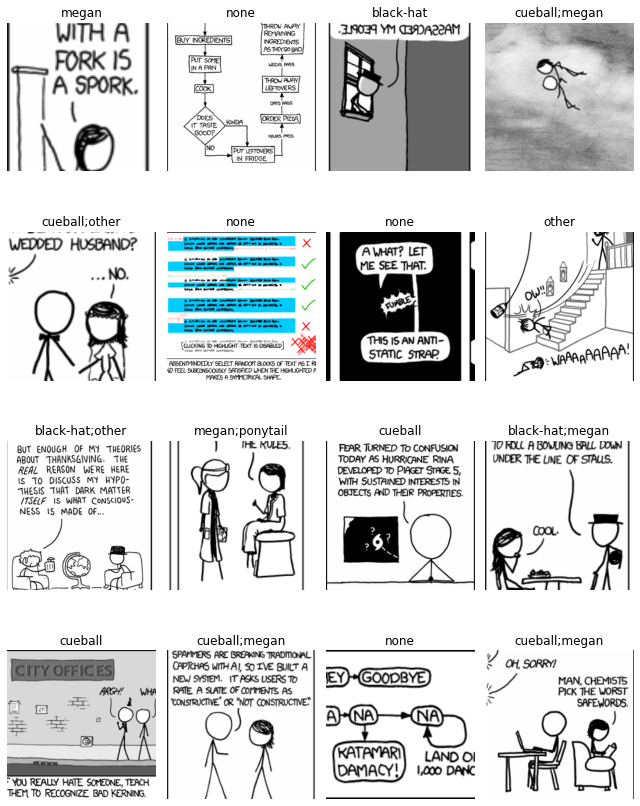

In [8]:
data.show_batch(rows=4,figsize=(9,12))

## Training Model

###  First Pass

In [0]:
arch=models.resnet50;
acc_02 = partial(accuracy_thresh, thresh=0.2);

In [0]:
learn = cnn_learner(data,arch,metrics=acc_02);

In [11]:
learn.lr_find();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


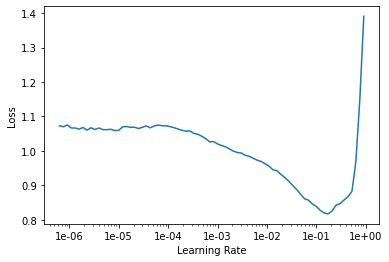

In [12]:
learn.recorder.plot()

In [0]:
lr = 3e-2;

In [17]:
learn.fit_one_cycle(7,slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.893302,0.822155,0.457103,00:05
1,0.605954,0.377335,0.881857,00:05
2,0.458987,0.343609,0.921238,00:05
3,0.373275,0.291148,0.911392,00:05
4,0.313851,0.260914,0.915612,00:05
5,0.252677,0.234008,0.924051,00:05
6,0.212077,0.219690,0.928270,00:05


In [0]:
learn.save('stage-1')

###  Fine-Tuning

In [0]:
learn.load('stage-1');
learn.unfreeze();

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


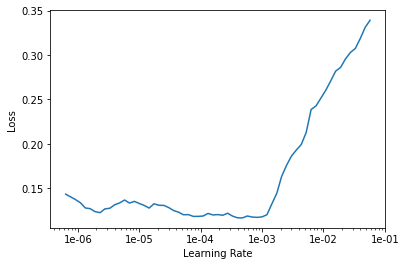

In [21]:
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(5,slice(3e-5,3e-4))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.136954,0.203160,0.932489,00:06
1,0.125167,0.230950,0.905767,00:06
2,0.125313,0.218930,0.933896,00:06
3,0.109851,0.229238,0.933896,00:06
4,0.097760,0.209928,0.935302,00:06


In [0]:
learn.save('stage-2')

### Interpretation

In [24]:
interp=ClassificationInterpretation.from_learner(learn);

11 misclassified samples over 79 samples in the validation set.


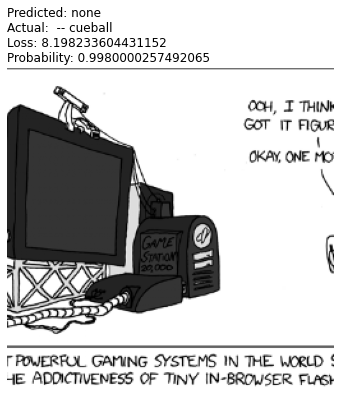

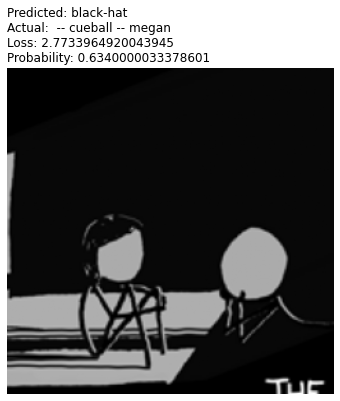

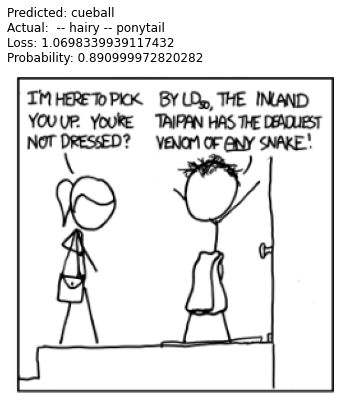

In [25]:
interp.plot_multi_top_losses(3,figsize=(6,6))

Classifier perfomance greatly improved with cropped/centered panels, rather than large and unmodified images.  

Some misclassifications are results of improper crops by DataLoader.   

Datasets might be too small to properly assess accuracy.




## Production

In [0]:
learn.export()